In [1]:
!pip install tensorflow
!pip install keras
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline

In [3]:
from google.colab import files
uploaded = files.upload()

Saving btc.csv to btc.csv


In [4]:
btc = pd.read_csv(io.StringIO(uploaded['btc.csv'].decode('utf-8')))
btc.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,5/25/2018,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,5/24/2018,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,5/23/2018,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,5/22/2018,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


In [5]:
# these columns will not be useful for our model
# we will work only with the opening and closing price of bitcoin
useful_btc_data = btc.drop(labels = ['Date', 'Symbol', 'Volume From', 'Volume To', 'High', 'Low'], axis = 1)

In [6]:
useful_btc_data.head()

,Open,Close
0,7459.11,7520.00
1,7584.15,7459.11
2,7505.00,7584.15
3,7987.70,7505.00
4,8393.44,7987.70


In [7]:
#drop rows with NaN data
clean_data = useful_btc_data.dropna()
clean_data.size

2546

In [8]:
data_array = clean_data.to_numpy()
data_array

array([[7459.11, 7520.  ],
       [7584.15, 7459.11],
       [7505.  , 7584.15],
       ...,
       [ 378.  ,  378.  ],
       [ 370.  ,  378.  ],
       [ 300.  ,  370.  ]])

In [9]:
# we are going to convert this 2-d array to a 1-d array
flatten_data = data_array.flatten().reshape(-1, 1)
flatten_data

array([[7459.11],
       [7520.  ],
       [7584.15],
       ...,
       [ 378.  ],
       [ 300.  ],
       [ 370.  ]])

In [10]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(flatten_data)
scaled_data

array([[ 1.30947341],
       [ 1.32555627],
       [ 1.34250021],
       ...,
       [-0.56085933],
       [-0.58146147],
       [-0.56297237]])

In [176]:
# to predict the closing price of btc in a given day, we are going to use historical
# data (openning and closing price of btc from the previous days) as well as the openning price 
# of btc of the given day

class WindowData():
  def __init__(self, raw_data, window_size, train_frac = 0.8, test_frac = 0.2):
    self.raw_data = raw_data
    self.window_size = window_size
    #we are only predicting closing prices
    length = raw_data.size // 2
    self.test_size = int(length * test_frac)
    self.train_size = length - self.test_size
    assert self.train_size + self.test_size == length

  def initialize(self):
    input = self.raw_data
    window_size = self.window_size
    data, labels = [], []
    for i in range(0, input.size - window_size, 2):
      cur_window = input[i:i+window_size]
      # append firs values to X_data
      data.append(cur_window[:-1].reshape(-1, 1))
      # last value of the range is what we want to predict (closing value for the last day)
      labels.append(cur_window[-1:].reshape(-1, 1))

    self.data = np.array(data)
    self.labels = np.array(labels)

  @property
  def X_train(self):
    return self.data[0:self.train_size]

  @property
  def y_train(self):
    return self.labels[0:self.train_size]

  @property
  def X_test(self):
    return self.data[-self.test_size:]
  
  @property
  def y_test(self):
    return self.labels[-self.test_size:]   

  @property
  def X(self):
    return self.data

  @property
  def y(self):
    return self.labels

In [177]:
window_size = 10
windowed_data = WindowData(scaled_data, window_size)
windowed_data.initialize()

In [178]:
def build_model(optimizer, lstm_activation, lstm_kernel_init, lstm_recur_init):
  #now we have our data windowed, we have to create our model
  lstm_model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(units = 1,
                           return_sequences=False,
                           kernel_initializer = lstm_kernel_init,
                           recurrent_initializer = lstm_recur_init,
                           ),
      tf.keras.layers.Dense(units=1)
  ])

  lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.metrics.MeanAbsoluteError()])

  return lstm_model

In [179]:
def fit_model(model, X_train, y_train, validation_split, max_epochs, patience=10):
  # this will stop the training if we do not decrease the loss within 'patience' epochs
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  mode='min')
  
  history = model.fit(X_train, y_train, epochs=max_epochs,
                  validation_split=validation_split,
                  callbacks=[early_stopping])
  
  return history

In [180]:
X_train = windowed_data.X_train
y_train = windowed_data.y_train

We define the following parameters to execute the grid search:

In [181]:
optimizer_params = [tf.optimizers.Adam()]
activation_params = ["tanh"]
kernel_initializer_params = ["glorot_uniform"]
recurrent_initializer_params = ["orthogonal"]

Here, we iterate over all possible parameters configurations and select the best model. We save this model so we can reload it later.

In [182]:
def grid_search(opt_params, act_params, ker_params, rec_params,
                validation_frac = 0.15, max_epochs = 1000,
                model_out_path = "best_model"):
  best_loss = None
  for opt in opt_params:
    for act in act_params:
      for ker in ker_params:
        for rec in rec_params:
          model = build_model(opt, act, ker, rec)
          history = fit_model(model, X_train, y_train, validation_frac, max_epochs, patience = 15)
          final_loss = history.history["loss"][-1]
          if best_loss == None or final_loss < best_loss:
            best_loss = final_loss
            model.save(model_out_path, overwrite = True)

In [183]:
grid_search(optimizer_params, activation_params,
            kernel_initializer_params, recurrent_initializer_params)

Epoch 1/1000
28/28 [==============================] - 3s 25ms/step - loss: 1.2288 - mean_absolute_error: 0.7709 - val_loss: 0.3426 - val_mean_absolute_error: 0.5849
Epoch 2/1000
28/28 [==============================] - 0s 7ms/step - loss: 1.0993 - mean_absolute_error: 0.7508 - val_loss: 0.3603 - val_mean_absolute_error: 0.5999
Epoch 3/1000
28/28 [==============================] - 0s 6ms/step - loss: 1.0406 - mean_absolute_error: 0.7424 - val_loss: 0.3694 - val_mean_absolute_error: 0.6075
Epoch 4/1000
28/28 [==============================] - 0s 6ms/step - loss: 0.9683 - mean_absolute_error: 0.7196 - val_loss: 0.3781 - val_mean_absolute_error: 0.6146
Epoch 5/1000
28/28 [==============================] - 0s 6ms/step - loss: 1.0664 - mean_absolute_error: 0.7559 - val_loss: 0.3844 - val_mean_absolute_error: 0.6196
Epoch 6/1000
28/28 [==============================] - 0s 6ms/step - loss: 0.9820 - mean_absolute_error: 0.7305 - val_loss: 0.3824 - val_mean_absolute_error: 0.6180
Epoch 7/1000
28

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


Now, we load our best model to analyze its performance

In [184]:
from keras.models import load_model

lstm_model = load_model("best_model")

In [185]:
X_test = windowed_data.X_test
y_test = windowed_data.y_test

In [186]:
lstm_model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 2ms/step - loss: 9.3326e-04 - mean_absolute_error: 0.0303


[0.0009332640911452472, 0.030285673215985298]

In [187]:
def plot(y_test, y_pred):
  plt.clf()
  plt.xlabel('time')
  plt.ylabel('btc_scaled_price_usd')
  plt.plot(y_test, '-b', label='real_vals')
  plt.plot(y_pred, '--r', label='predicted_vals')
  plt.legend()
  plt.title('Bitcoin real price vs predicted price')
  plt.show()

In [188]:
y_pred = lstm_model.predict(X_test)

Now, we can analyze our model with a graph of the actual btc price versus the btc price predicted by our model in the test set

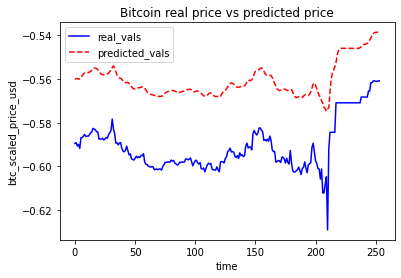

In [189]:
plot(y_test.reshape(-1), y_pred.reshape(-1))

In [190]:
y = windowed_data.y.reshape(-1)
y_pred = lstm_model.predict(windowed_data.X).reshape(-1)

Next, we have a grahp for the bitcoin price in the whole dataset (training and test)

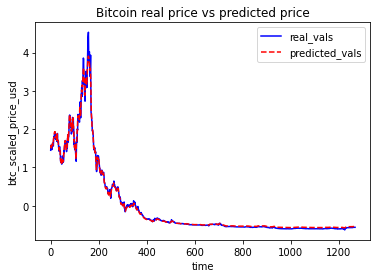

In [191]:
plot(y, y_pred)